## ************************ Tow related video files are available in the repo! ************************

# Part A


- **Discrete Latent Space:** VQ-VAE is argued to effectively model important features that span many dimensions in data space, such as objects in images or phonemes in speech. The discrete latent space allows the model to focus on essential information rather than noise and imperceptible details.Discrete representations are potentially a more natural fit for many of the modalities we are interested in. Language is inherently discrete, similarly speech is typically represented as a sequence of symbols. Images can often be described concisely by language. Furthermore, discrete representations are a natural fit for complex reasoning.





- **Posterior Collapse:** The VQ-VAE model is designed to avoid the "posterior collapse" issue, where latent variables are ignored, often caused by powerful decoders in VAE models.

# Part B

In [2]:
# Import libraries
import os
import cv2
import glob
import torch
import shutil
import random
import argparse
import torchvision

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from einops import einsum
from einops import rearrange
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataloader import DataLoader

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset_temp = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_temp = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [4]:
# Create MnistDataset from loaded dataset and implement number of channels (1 or 3)
class MnistDataset(Dataset):
    def __init__(self, split, im_channels):
        self.split = split
        self.im_channels = im_channels
        self.images, self.labels = self.load_images(split)

    def load_images(self,split):
        ims = []
        labels = []
        for idx in range(split.__len__()):
            img, label = split.__getitem__(idx)
            ims.append(np.array(img).reshape(28,28))
            labels.append(label)

        return ims, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if self.im_channels == 1:
            im = self.images[index]
        else:
            # Generate a random color digit
            im_1 = self.images[index][None, :]*np.clip(random.random(), 0.2, 1.0)
            im_2 = self.images[index][None, :]*np.clip(random.random(), 0.2, 1.0)
            im_3 = self.images[index][None, :]*np.clip(random.random(), 0.2, 1.0)
            im = np.concatenate([im_1, im_2, im_3], axis=0)

        label = self.labels[index]
#         im = 2*im -1
        im_tensor = torch.from_numpy(im)[None, :] if self.im_channels == 1 else torch.from_numpy(im)
        return im_tensor, torch.as_tensor(label)

In [5]:
# Create mnist dataset object
mnist = MnistDataset(split=train_dataset_temp, im_channels=3)

# Create dataloader with batch_size = 128 
mnist_loader = DataLoader(mnist, batch_size=128, shuffle=True, num_workers=0)
for im, label in mnist_loader:
    print('Image dimension:', im.shape)
    print('Label dimension: {}'.format(label.shape))
    break

Image dimension: torch.Size([128, 3, 28, 28])
Label dimension: torch.Size([128])


# Part C, D, & E

In [6]:
# Implement VQVAE claa
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        
        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),)
        
        self.pre_quant_conv = nn.Conv2d(4, 2, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=2)
        self.post_quant_conv = nn.Conv2d(2, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),)
        
    # forward path
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        # Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Save embedding weights(code book vectors)
        codebookvecs = self.embedding.weight
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses, quant_out, codebookvecs

# Part F

In [18]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
model = VQVAE().to(device)

# Set train parameters
num_epochs = 20
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# For store total loss in each iteration
totalLossPlot = []

# for gif and plot (G and H)
iternum = 0

input_images_for_show = []
output_images_for_show = []
quantized_iamges_for_show = []
codebookvecs_for_show = []


# Train loop
for epoch_idx in range(num_epochs):
    model.train()
    totloss_per_epoch = []
    recons_losses = []
    quant_loss = []
    
    # loop through batchs
    for im, label in tqdm(mnist_loader):
        
        im = im.float().to(device)
        optimizer.zero_grad()
        out, quantize_loss, quant_output, codebookvecs = model(im)

        recon_loss = criterion(out, im)
        loss = recon_loss + quantize_loss
        loss.backward()
        optimizer.step()
        totalLossPlot.append(loss.item())
        totloss_per_epoch.append(loss.item())
        recons_losses.append(recon_loss.item())
        quant_loss.append(quantize_loss.item())
        
        # save for show
        if (iternum%20) == 0 :
            # Save to lists for show
            input_images_for_show.append(im.detach()[0])
            
            output_images_for_show.append(out.detach()[0])
            
            quantized_iamges_for_show.append(quant_output.detach()[0])
            
            codebookvecs_for_show.append(codebookvecs.detach())
            
        iternum +=1
        
    print('Finished epoch:{} || Tatal Loss:{:.4f} || Reconstruction Loss:{:.4f} || Quantization Loss:{:.4f}'.format(epoch_idx+1, np.mean(totloss_per_epoch), np.mean(recons_losses), np.mean(quant_loss)))

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.60it/s]


Finished epoch:1 || Tatal Loss:0.1854 || Reconstruction Loss:0.0391 || Quantization Loss:0.1463


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.54it/s]


Finished epoch:2 || Tatal Loss:0.0509 || Reconstruction Loss:0.0188 || Quantization Loss:0.0320


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.62it/s]


Finished epoch:3 || Tatal Loss:0.0473 || Reconstruction Loss:0.0181 || Quantization Loss:0.0292


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.68it/s]


Finished epoch:4 || Tatal Loss:0.0453 || Reconstruction Loss:0.0178 || Quantization Loss:0.0275


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:39<00:00, 11.76it/s]


Finished epoch:5 || Tatal Loss:0.0455 || Reconstruction Loss:0.0176 || Quantization Loss:0.0279


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.57it/s]


Finished epoch:6 || Tatal Loss:0.0451 || Reconstruction Loss:0.0176 || Quantization Loss:0.0275


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.55it/s]


Finished epoch:7 || Tatal Loss:0.0432 || Reconstruction Loss:0.0175 || Quantization Loss:0.0257


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.61it/s]


Finished epoch:8 || Tatal Loss:0.0433 || Reconstruction Loss:0.0174 || Quantization Loss:0.0259


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.59it/s]


Finished epoch:9 || Tatal Loss:0.0442 || Reconstruction Loss:0.0173 || Quantization Loss:0.0269


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.62it/s]


Finished epoch:10 || Tatal Loss:0.0410 || Reconstruction Loss:0.0171 || Quantization Loss:0.0239


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.63it/s]


Finished epoch:11 || Tatal Loss:0.0368 || Reconstruction Loss:0.0181 || Quantization Loss:0.0187


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.64it/s]


Finished epoch:12 || Tatal Loss:0.0350 || Reconstruction Loss:0.0192 || Quantization Loss:0.0158


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.54it/s]


Finished epoch:13 || Tatal Loss:0.0346 || Reconstruction Loss:0.0206 || Quantization Loss:0.0139


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.55it/s]


Finished epoch:14 || Tatal Loss:0.0345 || Reconstruction Loss:0.0213 || Quantization Loss:0.0132


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.56it/s]


Finished epoch:15 || Tatal Loss:0.0337 || Reconstruction Loss:0.0220 || Quantization Loss:0.0117


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.56it/s]


Finished epoch:16 || Tatal Loss:0.0246 || Reconstruction Loss:0.0138 || Quantization Loss:0.0108


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.55it/s]


Finished epoch:17 || Tatal Loss:0.0234 || Reconstruction Loss:0.0132 || Quantization Loss:0.0103


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.53it/s]


Finished epoch:18 || Tatal Loss:0.0241 || Reconstruction Loss:0.0132 || Quantization Loss:0.0109


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.48it/s]


Finished epoch:19 || Tatal Loss:0.0242 || Reconstruction Loss:0.0132 || Quantization Loss:0.0110


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.58it/s]

Finished epoch:20 || Tatal Loss:0.0239 || Reconstruction Loss:0.0133 || Quantization Loss:0.0106


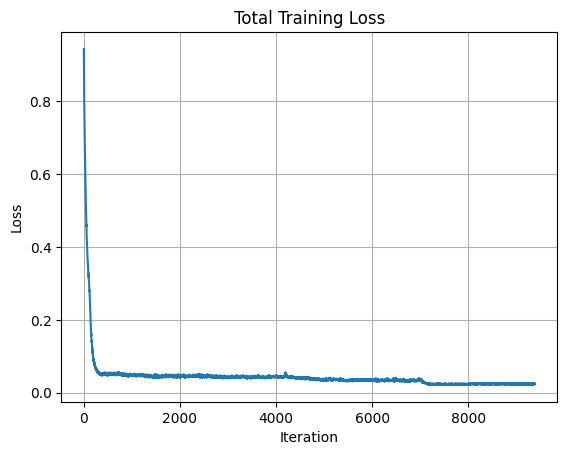

In [26]:
# plot loss
plt.plot(np.arange(1,num_epochs*469+1), totalLossPlot)
plt.title('Total Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Part G

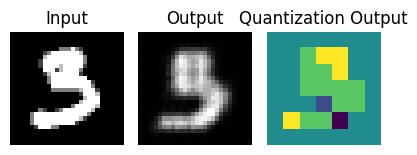

<Figure size 640x480 with 0 Axes>

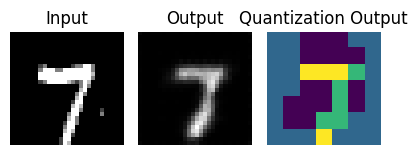

<Figure size 640x480 with 0 Axes>

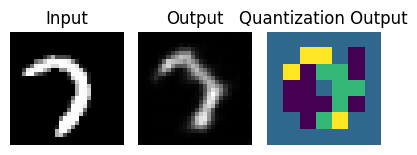

<Figure size 640x480 with 0 Axes>

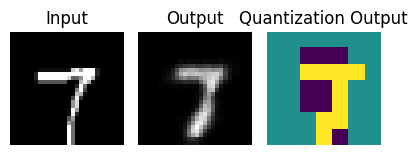

<Figure size 640x480 with 0 Axes>

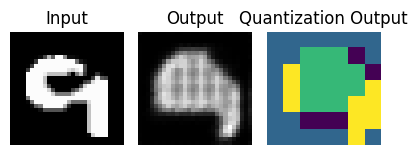

<Figure size 640x480 with 0 Axes>

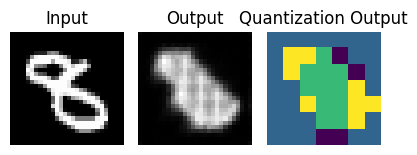

<Figure size 640x480 with 0 Axes>

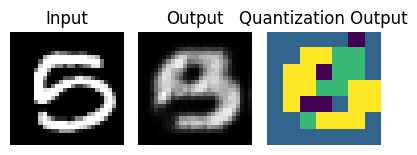

<Figure size 640x480 with 0 Axes>

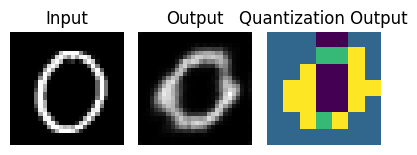

<Figure size 640x480 with 0 Axes>

In [35]:
# Plot Input, Output, Quantization Output for some datapoints

# Define the plot titles
image_names = ['Input', 'Output', 'Quantization Output']

for i in range(8):
    
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))

    # Plot input image
    axes[0].imshow(np.array(input_images_for_show[i+200][0]).reshape(28,28), cmap='gray')
    axes[0].set_title(image_names[0])
    axes[0].set_axis_off()

    # Plot output image
    axes[1].imshow(np.array(output_images_for_show[i+200][0]).reshape(28,28), cmap='gray')
    axes[1].set_title(image_names[1])
    axes[1].set_axis_off()

    # Plot Codebook Output, Sum of channels
    axes[2].imshow((np.array(quantized_iamges_for_show[i+200][0]) + np.array(quantized_iamges_for_show[i][1]) ).reshape(7,7))
    axes[2].set_title(image_names[2])
    axes[2].set_axis_off()

    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    plt.figure()

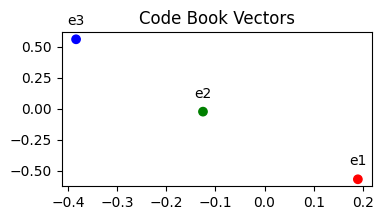

In [36]:
# Plot Codebooks
fig, ax = plt.subplots(figsize=(4, 2))
e_s = np.array(codebookvecs_for_show[-1])
x = e_s[:,0]
y = e_s[:,1]

# set label and color for each vector
labels = ['e1', 'e2', 'e3']
colors = ['red', 'green', 'blue']

# Scatter plot
scatter = ax.scatter(x, y, c=colors, label=labels)

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Set plot title and labels
ax.set_title('Code Book Vectors')

plt.show()

# Part H

In [22]:
# A function for get codebooke vectors and save them as an image
def create_image_coodbookvecs(vecs, indexname):
    # Get codebook vectors
    e_s = np.array(vecs.detach())
    x = e_s[:,0]
    y = e_s[:,1]

    # set label and color for each vector
    labels = ['e1', 'e2', 'e3']
    colors = ['red', 'green', 'blue']

    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 4))

    # Scatter plot
    scatter = ax.scatter(x, y, c=colors, label=labels)

    # Annotate each point with its label
    for i, label in enumerate(labels):
        ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Set plot title and labels
    ax.set_title(f'Code Book Vectors Iteration:{indexname*20+1}')

    # Save the plot
    fig.savefig(f'codebookvectors/codebookvecs_iter_{indexname+1}.png')

    # Close the figure
    plt.close(fig)

In [11]:
# Apply the function on the codebook list to create the frames
for i in tqdm(range(len(codebookvecs_for_show))):
    create_image_coodbookvecs(codebookvecs_for_show[i],i)

100%|████████████████████████████████████████████████████████████████████████████████| 587/587 [00:58<00:00,  9.99it/s]


In [12]:
# Make a video from stored plots
image_folder = 'codebookvectors'

# Output video file name
video_name = 'codebook_vectors_video.avi'

# Frame rate
fps = 10

# Get H and W
frame = cv2.imread(f'codebookvectors/codebookvecs_iter_{1}.png')
height, width, _ = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Loop through images and write it to the video
for i in range(len(input_images_for_show)):
    frame = cv2.imread(f'codebookvectors/codebookvecs_iter_{i+1}.png')
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.write(frame)

# Release the VideoWriter
video.release()
cv2.destroyAllWindows()
print('Done!')

Done!


In [24]:
# create plots and save them  as frames for  Input/Output/Quantization video
image_names = ['Input', 'Output', 'Quantization Output']

for i in tqdm(range(len(input_images_for_show))):
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    # Plot input image
    axes[0].imshow(np.array(input_images_for_show[i][0]).reshape(28,28), cmap='gray')
    axes[0].set_title(image_names[0])
    axes[0].set_axis_off()

    # Plot output image
    axes[1].imshow(np.array(output_images_for_show[i][0]).reshape(28,28), cmap='gray')
    axes[1].set_title(image_names[1])
    axes[1].set_axis_off()

    # Plot Codebook Output, Sum of channels
    axes[2].imshow((np.array(quantized_iamges_for_show[i][0]) + np.array(quantized_iamges_for_show[i][1])).reshape(7,7))
    axes[2].set_title(image_names[2])
    axes[2].set_axis_off()
    
    # Set a title for the entireplot
    fig.suptitle(f'Iteration:{i*20+1}', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    fig.savefig(f'IOQ/IOQ_iter_{i+1}.png')

    # Close the figure
    plt.close(fig)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [02:21<00:00,  3.32it/s]


In [25]:
# Make a video from stored plots
image_folder = 'IOQ'

# Output video file name
video_name = 'IOQ_video.avi'

# Frame rate
fps = 5

# Get H and W
frame = cv2.imread(f'IOQ/IOQ_iter_{1}.png')
height, width, _ = frame.shape


# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Loop through each image and write it to the video
for i in tqdm(range(len(input_images_for_show))):
    frame = cv2.imread(f'IOQ/IOQ_iter_{i+1}.png')
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.write(frame)

# Release the VideoWriter
video.release()
cv2.destroyAllWindows()
print('Done!')

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 49.08it/s]

Done!


# Part I (RGB MNIST)

## a

In [37]:
# Create  Colored MNIST (RGB) dataset object, set im_channels = 3
mnist_rgb = MnistDataset(split=train_dataset_temp, im_channels=3)

# Create dataloader with batch_size = 128
mnist_loader_rgb = DataLoader(mnist_rgb, batch_size=128, shuffle=True, num_workers=0)
for im, label in mnist_loader_rgb:
    print('Image dimension:', im.shape)
    print('Label dimension: {}'.format(label.shape))
    break

Image dimension: torch.Size([128, 3, 28, 28])
Label dimension: torch.Size([128])


In [38]:
# A function for plot MNIST RGB images
def rgb_to_plot(tensor_rgb):
    temp = np.zeros((28,28,3))
    temp[:,:,0] = tensor_rgb[0,:,:]
    temp[:,:,1] = tensor_rgb[1,:,:]
    temp[:,:,2] = tensor_rgb[2,:,:]
    return temp

## b

In [39]:
# Create a VQVAERGB class for 3-channel images
class VQVAERGB(nn.Module):
    def __init__(self, numvectors, dimvectors):
        super(VQVAERGB, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),)
        
        self.pre_quant_conv = nn.Conv2d(4, dimvectors, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=numvectors, embedding_dim=dimvectors)
        self.post_quant_conv = nn.Conv2d(dimvectors, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),)
        
        
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        # Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        # Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses

In [40]:
def train_rgb(model_rgb , num_epochs):
    
    # Set training parameters
    optimizer = Adam(model_rgb.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # Training loop
    for epoch_idx in range(num_epochs):
        model_rgb.train()
        totloss_per_epoch = []
        recuns_loss = []
        quant_loss = []

        # Loop through the batches
        for im, label in tqdm(mnist_loader_rgb):
            im = im.float().to(device)
            optimizer.zero_grad()
            out, quantize_loss = model_rgb(im)

            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()
            totloss_per_epoch.append(loss.item())
            recuns_loss.append(recon_loss.item())
            quant_loss.append(quantize_loss.item())
        print('Finished epoch:{} || Total Loss:{:.4f} || Reconstruction Loss:{:.4f} || Quantization Loss:{:.4f}'.format(epoch_idx+1, np.mean(totloss_per_epoch), np.mean(recuns_loss), np.mean(quant_loss)))
    
    
    # get a output batch for plot the images
    model_rgb.eval()
    
    # Loop through the batches
    for im, label in mnist_loader_rgb:
        im = im.float().to(device)
        final_output, _ = model_rgb(im)
      
    print('**************************************************************************************************')
    
    return final_output
    
    

In [16]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of codebook vectros
numvecs = [3, 10, 25, 50]

# Define a dict for save the outputs of models
outputs_numvecs = {}

# Loop through the number of codebook vectors
for num in numvecs:
    
    # Create a model and move to the device
    model_rgb = VQVAERGB(numvectors=num, dimvectors=2).to(device)
    
    # train for 20 epochs
    output_batch = train_rgb(model_rgb = model_rgb , num_epochs = 20 )
    
    # save the outputs for comprasion
    outputs_numvecs[num] = output_batch
    

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.27it/s]


Finished epoch:1 || Total Loss:0.0571 || Reconstruction Loss:0.0414 || Quantization Loss:0.0157


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.08it/s]


Finished epoch:2 || Total Loss:0.0527 || Reconstruction Loss:0.0256 || Quantization Loss:0.0271


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 33.86it/s]


Finished epoch:3 || Total Loss:0.0337 || Reconstruction Loss:0.0174 || Quantization Loss:0.0162


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.74it/s]


Finished epoch:4 || Total Loss:0.0357 || Reconstruction Loss:0.0177 || Quantization Loss:0.0180


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 32.86it/s]


Finished epoch:5 || Total Loss:0.0381 || Reconstruction Loss:0.0181 || Quantization Loss:0.0200


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.81it/s]


Finished epoch:6 || Total Loss:0.0383 || Reconstruction Loss:0.0186 || Quantization Loss:0.0197


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.58it/s]


Finished epoch:7 || Total Loss:0.0372 || Reconstruction Loss:0.0190 || Quantization Loss:0.0181


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.97it/s]


Finished epoch:8 || Total Loss:0.0361 || Reconstruction Loss:0.0195 || Quantization Loss:0.0166


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.82it/s]


Finished epoch:9 || Total Loss:0.0363 || Reconstruction Loss:0.0197 || Quantization Loss:0.0166


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.56it/s]


Finished epoch:10 || Total Loss:0.0366 || Reconstruction Loss:0.0198 || Quantization Loss:0.0168


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.53it/s]


Finished epoch:11 || Total Loss:0.0370 || Reconstruction Loss:0.0199 || Quantization Loss:0.0171


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.76it/s]


Finished epoch:12 || Total Loss:0.0371 || Reconstruction Loss:0.0202 || Quantization Loss:0.0169


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.07it/s]


Finished epoch:13 || Total Loss:0.0369 || Reconstruction Loss:0.0205 || Quantization Loss:0.0163


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.30it/s]


Finished epoch:14 || Total Loss:0.0370 || Reconstruction Loss:0.0209 || Quantization Loss:0.0161


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.70it/s]


Finished epoch:15 || Total Loss:0.0362 || Reconstruction Loss:0.0210 || Quantization Loss:0.0151


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 32.24it/s]


Finished epoch:16 || Total Loss:0.0362 || Reconstruction Loss:0.0214 || Quantization Loss:0.0148


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.34it/s]


Finished epoch:17 || Total Loss:0.0367 || Reconstruction Loss:0.0226 || Quantization Loss:0.0142


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 31.11it/s]


Finished epoch:18 || Total Loss:0.0368 || Reconstruction Loss:0.0230 || Quantization Loss:0.0138


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.43it/s]


Finished epoch:19 || Total Loss:0.0355 || Reconstruction Loss:0.0231 || Quantization Loss:0.0124


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.40it/s]


Finished epoch:20 || Total Loss:0.0362 || Reconstruction Loss:0.0231 || Quantization Loss:0.0132
**************************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.32it/s]


Finished epoch:1 || Total Loss:0.0994 || Reconstruction Loss:0.0298 || Quantization Loss:0.0696


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.86it/s]


Finished epoch:2 || Total Loss:0.0239 || Reconstruction Loss:0.0142 || Quantization Loss:0.0097


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.57it/s]


Finished epoch:3 || Total Loss:0.0226 || Reconstruction Loss:0.0131 || Quantization Loss:0.0096


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.08it/s]


Finished epoch:4 || Total Loss:0.0213 || Reconstruction Loss:0.0122 || Quantization Loss:0.0091


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.66it/s]


Finished epoch:5 || Total Loss:0.0181 || Reconstruction Loss:0.0113 || Quantization Loss:0.0068


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.76it/s]


Finished epoch:6 || Total Loss:0.0160 || Reconstruction Loss:0.0107 || Quantization Loss:0.0053


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.64it/s]


Finished epoch:7 || Total Loss:0.0157 || Reconstruction Loss:0.0104 || Quantization Loss:0.0052


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.55it/s]


Finished epoch:8 || Total Loss:0.0156 || Reconstruction Loss:0.0102 || Quantization Loss:0.0054


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.62it/s]


Finished epoch:9 || Total Loss:0.0155 || Reconstruction Loss:0.0100 || Quantization Loss:0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.01it/s]


Finished epoch:10 || Total Loss:0.0151 || Reconstruction Loss:0.0099 || Quantization Loss:0.0053


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.30it/s]


Finished epoch:11 || Total Loss:0.0150 || Reconstruction Loss:0.0095 || Quantization Loss:0.0054


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.44it/s]


Finished epoch:12 || Total Loss:0.0150 || Reconstruction Loss:0.0093 || Quantization Loss:0.0057


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.26it/s]


Finished epoch:13 || Total Loss:0.0154 || Reconstruction Loss:0.0091 || Quantization Loss:0.0063


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.03it/s]


Finished epoch:14 || Total Loss:0.0158 || Reconstruction Loss:0.0091 || Quantization Loss:0.0068


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.74it/s]


Finished epoch:15 || Total Loss:0.0164 || Reconstruction Loss:0.0090 || Quantization Loss:0.0073


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.69it/s]


Finished epoch:16 || Total Loss:0.0168 || Reconstruction Loss:0.0090 || Quantization Loss:0.0078


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.34it/s]


Finished epoch:17 || Total Loss:0.0178 || Reconstruction Loss:0.0088 || Quantization Loss:0.0090


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.16it/s]


Finished epoch:18 || Total Loss:0.0200 || Reconstruction Loss:0.0084 || Quantization Loss:0.0117


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.83it/s]


Finished epoch:19 || Total Loss:0.0200 || Reconstruction Loss:0.0079 || Quantization Loss:0.0121


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.27it/s]


Finished epoch:20 || Total Loss:0.0201 || Reconstruction Loss:0.0077 || Quantization Loss:0.0124
**************************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 31.25it/s]


Finished epoch:1 || Total Loss:0.0379 || Reconstruction Loss:0.0298 || Quantization Loss:0.0081


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 31.22it/s]


Finished epoch:2 || Total Loss:0.0165 || Reconstruction Loss:0.0132 || Quantization Loss:0.0033


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.06it/s]


Finished epoch:3 || Total Loss:0.0170 || Reconstruction Loss:0.0113 || Quantization Loss:0.0057


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.28it/s]


Finished epoch:4 || Total Loss:0.0157 || Reconstruction Loss:0.0100 || Quantization Loss:0.0057


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.55it/s]


Finished epoch:5 || Total Loss:0.0149 || Reconstruction Loss:0.0094 || Quantization Loss:0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.77it/s]


Finished epoch:6 || Total Loss:0.0149 || Reconstruction Loss:0.0091 || Quantization Loss:0.0058


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.57it/s]


Finished epoch:7 || Total Loss:0.0144 || Reconstruction Loss:0.0088 || Quantization Loss:0.0057


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.79it/s]


Finished epoch:8 || Total Loss:0.0145 || Reconstruction Loss:0.0086 || Quantization Loss:0.0060


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.88it/s]


Finished epoch:9 || Total Loss:0.0151 || Reconstruction Loss:0.0078 || Quantization Loss:0.0073


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.16it/s]


Finished epoch:10 || Total Loss:0.0156 || Reconstruction Loss:0.0069 || Quantization Loss:0.0087


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.67it/s]


Finished epoch:11 || Total Loss:0.0153 || Reconstruction Loss:0.0067 || Quantization Loss:0.0086


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.81it/s]


Finished epoch:12 || Total Loss:0.0151 || Reconstruction Loss:0.0065 || Quantization Loss:0.0086


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.45it/s]


Finished epoch:13 || Total Loss:0.0151 || Reconstruction Loss:0.0063 || Quantization Loss:0.0088


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.49it/s]


Finished epoch:14 || Total Loss:0.0151 || Reconstruction Loss:0.0061 || Quantization Loss:0.0090


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.61it/s]


Finished epoch:15 || Total Loss:0.0151 || Reconstruction Loss:0.0059 || Quantization Loss:0.0092


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 31.22it/s]


Finished epoch:16 || Total Loss:0.0149 || Reconstruction Loss:0.0058 || Quantization Loss:0.0091


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.71it/s]


Finished epoch:17 || Total Loss:0.0149 || Reconstruction Loss:0.0057 || Quantization Loss:0.0092


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.65it/s]


Finished epoch:18 || Total Loss:0.0148 || Reconstruction Loss:0.0056 || Quantization Loss:0.0092


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.79it/s]


Finished epoch:19 || Total Loss:0.0147 || Reconstruction Loss:0.0055 || Quantization Loss:0.0091


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.26it/s]


Finished epoch:20 || Total Loss:0.0148 || Reconstruction Loss:0.0055 || Quantization Loss:0.0093
**************************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.54it/s]


Finished epoch:1 || Total Loss:0.0444 || Reconstruction Loss:0.0318 || Quantization Loss:0.0126


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.35it/s]


Finished epoch:2 || Total Loss:0.0167 || Reconstruction Loss:0.0130 || Quantization Loss:0.0037


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.14it/s]


Finished epoch:3 || Total Loss:0.0148 || Reconstruction Loss:0.0118 || Quantization Loss:0.0031


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.54it/s]


Finished epoch:4 || Total Loss:0.0134 || Reconstruction Loss:0.0110 || Quantization Loss:0.0024


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.06it/s]


Finished epoch:5 || Total Loss:0.0128 || Reconstruction Loss:0.0102 || Quantization Loss:0.0025


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.50it/s]


Finished epoch:6 || Total Loss:0.0121 || Reconstruction Loss:0.0089 || Quantization Loss:0.0032


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.02it/s]


Finished epoch:7 || Total Loss:0.0118 || Reconstruction Loss:0.0080 || Quantization Loss:0.0038


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.50it/s]


Finished epoch:8 || Total Loss:0.0113 || Reconstruction Loss:0.0068 || Quantization Loss:0.0045


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.22it/s]


Finished epoch:9 || Total Loss:0.0111 || Reconstruction Loss:0.0063 || Quantization Loss:0.0048


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.11it/s]


Finished epoch:10 || Total Loss:0.0110 || Reconstruction Loss:0.0061 || Quantization Loss:0.0049


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.75it/s]


Finished epoch:11 || Total Loss:0.0110 || Reconstruction Loss:0.0059 || Quantization Loss:0.0051


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.52it/s]


Finished epoch:12 || Total Loss:0.0109 || Reconstruction Loss:0.0057 || Quantization Loss:0.0052


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.11it/s]


Finished epoch:13 || Total Loss:0.0107 || Reconstruction Loss:0.0055 || Quantization Loss:0.0052


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.35it/s]


Finished epoch:14 || Total Loss:0.0108 || Reconstruction Loss:0.0053 || Quantization Loss:0.0055


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.80it/s]


Finished epoch:15 || Total Loss:0.0109 || Reconstruction Loss:0.0052 || Quantization Loss:0.0057


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.23it/s]


Finished epoch:16 || Total Loss:0.0109 || Reconstruction Loss:0.0051 || Quantization Loss:0.0058


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.59it/s]


Finished epoch:17 || Total Loss:0.0109 || Reconstruction Loss:0.0050 || Quantization Loss:0.0059


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.73it/s]


Finished epoch:18 || Total Loss:0.0109 || Reconstruction Loss:0.0049 || Quantization Loss:0.0059


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.12it/s]


Finished epoch:19 || Total Loss:0.0109 || Reconstruction Loss:0.0049 || Quantization Loss:0.0060


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 23.51it/s]


Finished epoch:20 || Total Loss:0.0108 || Reconstruction Loss:0.0049 || Quantization Loss:0.0059
**************************************************************************************************


In [17]:
# A function for plot RGB image as a grid
def plot_rgb_grid(output_batch, title):
    
    batch = output_batch.detach()
    images = []
    
    for i in range(4):
        img_rgb_gen = rgb_to_plot(batch[i].reshape(3, 28, 28))
        images.append(img_rgb_gen)
    
    
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))

    # Plot each RGB image on the subplots
    axs[0, 0].imshow(images[0])
    axs[0, 1].imshow(images[1])
    axs[1, 0].imshow(images[2])
    axs[1, 1].imshow(images[3])

    # Hide the x and y axis labels
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Set a title for the entire grid
    fig.suptitle(f'Number of Codebook Vectors:{title}', fontsize=16)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()
    plt.figure()

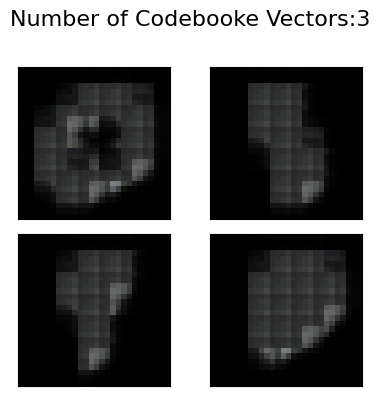

<Figure size 640x480 with 0 Axes>

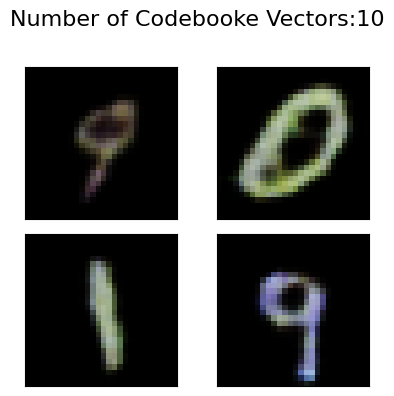

<Figure size 640x480 with 0 Axes>

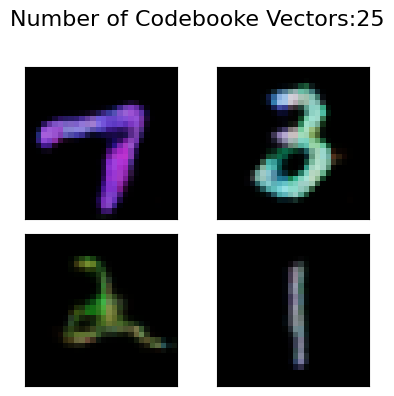

<Figure size 640x480 with 0 Axes>

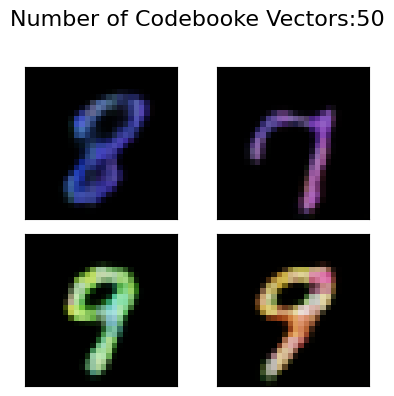

<Figure size 640x480 with 0 Axes>

In [18]:
# loop through the number of vectors
for num in numvecs:
    plot_rgb_grid(outputs_numvecs[num], num)

### As you see with more vectors in codebook, we can capture more information, color information and the quantization loss decreases, so the reconstructed images have higher resolution. Also the Total loss for 3,10,25, and 50 codebook vectors are 0.0362, 0.0201, 0.0148, and 0.0108  recpectively. As you see the loss decreases with increasment of codebook vectros number.

## c

In [41]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# list of dimansions of codebook vectors
dimansions = [10, 25, 40, 50]

# Define a dict for save the outputs of models
outputs_dims = {}

# Loop through the number of codebook vectors
for dim in dimansions:
    
    # Create a model and move to the device
    model_rgb = VQVAERGB(numvectors=3, dimvectors=dim).to(device)
    
    # train for 20 epochs
    output_batch = train_rgb(model_rgb = model_rgb , num_epochs = 20 )
    
    # save the outputs for comprasion
    outputs_dims[dim] = output_batch
    

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.29it/s]


Finished epoch:1 || Total Loss:0.2877 || Reconstruction Loss:0.0324 || Quantization Loss:0.2553


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.39it/s]


Finished epoch:2 || Total Loss:0.0328 || Reconstruction Loss:0.0192 || Quantization Loss:0.0136


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.45it/s]


Finished epoch:3 || Total Loss:0.0350 || Reconstruction Loss:0.0187 || Quantization Loss:0.0163


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.52it/s]


Finished epoch:4 || Total Loss:0.0358 || Reconstruction Loss:0.0185 || Quantization Loss:0.0174


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:40<00:00, 11.51it/s]


Finished epoch:5 || Total Loss:0.0354 || Reconstruction Loss:0.0187 || Quantization Loss:0.0168


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.19it/s]


Finished epoch:6 || Total Loss:0.0358 || Reconstruction Loss:0.0186 || Quantization Loss:0.0172


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 30.87it/s]


Finished epoch:7 || Total Loss:0.0365 || Reconstruction Loss:0.0186 || Quantization Loss:0.0179


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:15<00:00, 29.69it/s]


Finished epoch:8 || Total Loss:0.0360 || Reconstruction Loss:0.0185 || Quantization Loss:0.0175


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 31.80it/s]


Finished epoch:9 || Total Loss:0.0349 || Reconstruction Loss:0.0185 || Quantization Loss:0.0164


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.81it/s]


Finished epoch:10 || Total Loss:0.0347 || Reconstruction Loss:0.0185 || Quantization Loss:0.0163


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.12it/s]


Finished epoch:11 || Total Loss:0.0344 || Reconstruction Loss:0.0183 || Quantization Loss:0.0160


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.54it/s]


Finished epoch:12 || Total Loss:0.0351 || Reconstruction Loss:0.0183 || Quantization Loss:0.0168


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.54it/s]


Finished epoch:13 || Total Loss:0.0361 || Reconstruction Loss:0.0182 || Quantization Loss:0.0179


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.21it/s]


Finished epoch:14 || Total Loss:0.0375 || Reconstruction Loss:0.0181 || Quantization Loss:0.0194


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.18it/s]


Finished epoch:15 || Total Loss:0.0389 || Reconstruction Loss:0.0178 || Quantization Loss:0.0211


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 29.30it/s]


Finished epoch:16 || Total Loss:0.0408 || Reconstruction Loss:0.0178 || Quantization Loss:0.0231


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.30it/s]


Finished epoch:17 || Total Loss:0.0415 || Reconstruction Loss:0.0181 || Quantization Loss:0.0235


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.22it/s]


Finished epoch:18 || Total Loss:0.0420 || Reconstruction Loss:0.0183 || Quantization Loss:0.0237


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.65it/s]


Finished epoch:19 || Total Loss:0.0424 || Reconstruction Loss:0.0189 || Quantization Loss:0.0235


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.51it/s]


Finished epoch:20 || Total Loss:0.0411 || Reconstruction Loss:0.0192 || Quantization Loss:0.0219
**************************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.70it/s]


Finished epoch:1 || Total Loss:0.2986 || Reconstruction Loss:0.0363 || Quantization Loss:0.2623


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.47it/s]


Finished epoch:2 || Total Loss:0.0380 || Reconstruction Loss:0.0195 || Quantization Loss:0.0185


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.74it/s]


Finished epoch:3 || Total Loss:0.0436 || Reconstruction Loss:0.0193 || Quantization Loss:0.0244


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.06it/s]


Finished epoch:4 || Total Loss:0.0510 || Reconstruction Loss:0.0193 || Quantization Loss:0.0317


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 26.00it/s]


Finished epoch:5 || Total Loss:0.0493 || Reconstruction Loss:0.0192 || Quantization Loss:0.0301


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.18it/s]


Finished epoch:6 || Total Loss:0.0515 || Reconstruction Loss:0.0192 || Quantization Loss:0.0322


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.41it/s]


Finished epoch:7 || Total Loss:0.0520 || Reconstruction Loss:0.0192 || Quantization Loss:0.0328


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.48it/s]


Finished epoch:8 || Total Loss:0.0517 || Reconstruction Loss:0.0192 || Quantization Loss:0.0325


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.28it/s]


Finished epoch:9 || Total Loss:0.0499 || Reconstruction Loss:0.0191 || Quantization Loss:0.0307


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.96it/s]


Finished epoch:10 || Total Loss:0.0510 || Reconstruction Loss:0.0193 || Quantization Loss:0.0316


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.35it/s]


Finished epoch:11 || Total Loss:0.0510 || Reconstruction Loss:0.0203 || Quantization Loss:0.0308


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.32it/s]


Finished epoch:12 || Total Loss:0.0492 || Reconstruction Loss:0.0207 || Quantization Loss:0.0285


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.73it/s]


Finished epoch:13 || Total Loss:0.0453 || Reconstruction Loss:0.0206 || Quantization Loss:0.0247


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.52it/s]


Finished epoch:14 || Total Loss:0.0447 || Reconstruction Loss:0.0204 || Quantization Loss:0.0243


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.36it/s]


Finished epoch:15 || Total Loss:0.0427 || Reconstruction Loss:0.0203 || Quantization Loss:0.0225


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.58it/s]


Finished epoch:16 || Total Loss:0.0417 || Reconstruction Loss:0.0204 || Quantization Loss:0.0213


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.06it/s]


Finished epoch:17 || Total Loss:0.0427 || Reconstruction Loss:0.0204 || Quantization Loss:0.0223


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.03it/s]


Finished epoch:18 || Total Loss:0.0459 || Reconstruction Loss:0.0200 || Quantization Loss:0.0260


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.40it/s]


Finished epoch:19 || Total Loss:0.0454 || Reconstruction Loss:0.0205 || Quantization Loss:0.0249


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 28.00it/s]


Finished epoch:20 || Total Loss:0.0451 || Reconstruction Loss:0.0210 || Quantization Loss:0.0241
**************************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.69it/s]


Finished epoch:1 || Total Loss:0.4125 || Reconstruction Loss:0.0347 || Quantization Loss:0.3778


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.89it/s]


Finished epoch:2 || Total Loss:0.0535 || Reconstruction Loss:0.0182 || Quantization Loss:0.0353


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.47it/s]


Finished epoch:3 || Total Loss:0.0510 || Reconstruction Loss:0.0176 || Quantization Loss:0.0334


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.66it/s]


Finished epoch:4 || Total Loss:0.0490 || Reconstruction Loss:0.0173 || Quantization Loss:0.0317


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.65it/s]


Finished epoch:5 || Total Loss:0.0470 || Reconstruction Loss:0.0172 || Quantization Loss:0.0298


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.87it/s]


Finished epoch:6 || Total Loss:0.0451 || Reconstruction Loss:0.0170 || Quantization Loss:0.0280


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.23it/s]


Finished epoch:7 || Total Loss:0.0432 || Reconstruction Loss:0.0169 || Quantization Loss:0.0263


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.41it/s]


Finished epoch:8 || Total Loss:0.0410 || Reconstruction Loss:0.0167 || Quantization Loss:0.0243


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.31it/s]


Finished epoch:9 || Total Loss:0.0405 || Reconstruction Loss:0.0167 || Quantization Loss:0.0238


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.46it/s]


Finished epoch:10 || Total Loss:0.0414 || Reconstruction Loss:0.0170 || Quantization Loss:0.0244


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.81it/s]


Finished epoch:11 || Total Loss:0.0411 || Reconstruction Loss:0.0177 || Quantization Loss:0.0234


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.34it/s]


Finished epoch:12 || Total Loss:0.0387 || Reconstruction Loss:0.0189 || Quantization Loss:0.0198


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.90it/s]


Finished epoch:13 || Total Loss:0.0368 || Reconstruction Loss:0.0198 || Quantization Loss:0.0170


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.56it/s]


Finished epoch:14 || Total Loss:0.0368 || Reconstruction Loss:0.0203 || Quantization Loss:0.0165


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.01it/s]


Finished epoch:15 || Total Loss:0.0375 || Reconstruction Loss:0.0206 || Quantization Loss:0.0169


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.64it/s]


Finished epoch:16 || Total Loss:0.0379 || Reconstruction Loss:0.0213 || Quantization Loss:0.0166


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 24.81it/s]


Finished epoch:17 || Total Loss:0.0386 || Reconstruction Loss:0.0218 || Quantization Loss:0.0168


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.06it/s]


Finished epoch:18 || Total Loss:0.0411 || Reconstruction Loss:0.0225 || Quantization Loss:0.0187


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.59it/s]


Finished epoch:19 || Total Loss:0.0409 || Reconstruction Loss:0.0227 || Quantization Loss:0.0183


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.11it/s]


Finished epoch:20 || Total Loss:0.0407 || Reconstruction Loss:0.0228 || Quantization Loss:0.0179
**************************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.05it/s]


Finished epoch:1 || Total Loss:0.4188 || Reconstruction Loss:0.0358 || Quantization Loss:0.3830


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.52it/s]


Finished epoch:2 || Total Loss:0.0484 || Reconstruction Loss:0.0187 || Quantization Loss:0.0298


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.83it/s]


Finished epoch:3 || Total Loss:0.0423 || Reconstruction Loss:0.0185 || Quantization Loss:0.0239


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.79it/s]


Finished epoch:4 || Total Loss:0.0431 || Reconstruction Loss:0.0184 || Quantization Loss:0.0247


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.55it/s]


Finished epoch:5 || Total Loss:0.0479 || Reconstruction Loss:0.0186 || Quantization Loss:0.0293


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.75it/s]


Finished epoch:6 || Total Loss:0.0511 || Reconstruction Loss:0.0187 || Quantization Loss:0.0325


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 22.62it/s]


Finished epoch:7 || Total Loss:0.0534 || Reconstruction Loss:0.0187 || Quantization Loss:0.0347


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.39it/s]


Finished epoch:8 || Total Loss:0.0532 || Reconstruction Loss:0.0187 || Quantization Loss:0.0346


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.87it/s]


Finished epoch:9 || Total Loss:0.0622 || Reconstruction Loss:0.0189 || Quantization Loss:0.0433


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.49it/s]


Finished epoch:10 || Total Loss:0.0751 || Reconstruction Loss:0.0203 || Quantization Loss:0.0548


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.73it/s]


Finished epoch:11 || Total Loss:0.0721 || Reconstruction Loss:0.0209 || Quantization Loss:0.0512


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:25<00:00, 18.65it/s]


Finished epoch:12 || Total Loss:0.0646 || Reconstruction Loss:0.0219 || Quantization Loss:0.0428


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:22<00:00, 20.64it/s]


Finished epoch:13 || Total Loss:0.0582 || Reconstruction Loss:0.0208 || Quantization Loss:0.0374


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.87it/s]


Finished epoch:14 || Total Loss:0.0519 || Reconstruction Loss:0.0216 || Quantization Loss:0.0303


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 20.32it/s]


Finished epoch:15 || Total Loss:0.0499 || Reconstruction Loss:0.0216 || Quantization Loss:0.0283


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.58it/s]


Finished epoch:16 || Total Loss:0.0475 || Reconstruction Loss:0.0212 || Quantization Loss:0.0263


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.48it/s]


Finished epoch:17 || Total Loss:0.0432 || Reconstruction Loss:0.0202 || Quantization Loss:0.0230


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.81it/s]


Finished epoch:18 || Total Loss:0.0439 || Reconstruction Loss:0.0201 || Quantization Loss:0.0238


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.13it/s]


Finished epoch:19 || Total Loss:0.0435 || Reconstruction Loss:0.0203 || Quantization Loss:0.0232


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 21.73it/s]


Finished epoch:20 || Total Loss:0.0409 || Reconstruction Loss:0.0203 || Quantization Loss:0.0206
**************************************************************************************************


In [44]:
# A function for plot RGB image as a grid
def plot_rgb_grid(output_batch, title):
    
    batch = output_batch.detach()
    images = []
    
    for i in range(4):
        img_rgb_gen = rgb_to_plot(batch[i].reshape(3, 28, 28))
        images.append(img_rgb_gen)
    
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))

    # Plot each RGB image on the subplots
    axs[0, 0].imshow(images[0])
    axs[0, 1].imshow(images[1])
    axs[1, 0].imshow(images[2])
    axs[1, 1].imshow(images[3])

    # Hide the x and y axis labels
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Set a title for the entire grid
    fig.suptitle(f'Dimansion of Codebook Vectors:{title}', fontsize=16)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()
    plt.figure()

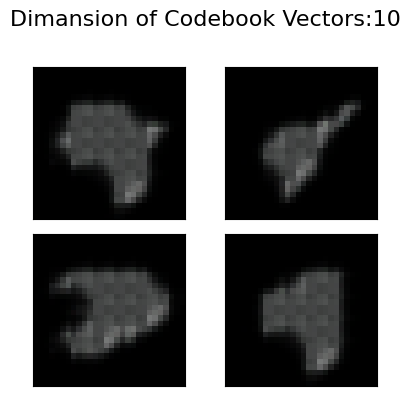

<Figure size 640x480 with 0 Axes>

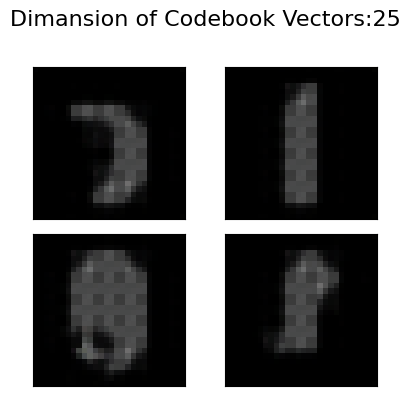

<Figure size 640x480 with 0 Axes>

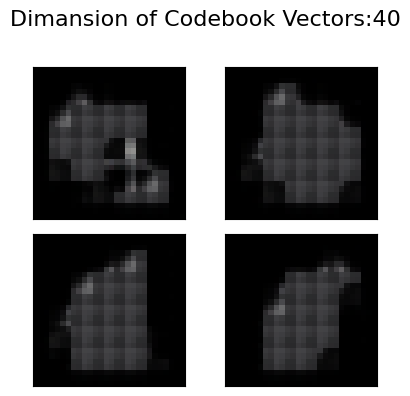

<Figure size 640x480 with 0 Axes>

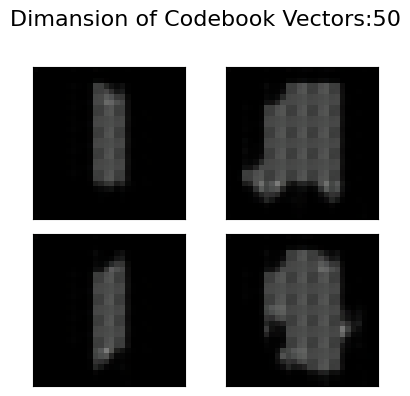

<Figure size 640x480 with 0 Axes>

In [45]:
# Loop through the dimansions and plot outputs
for dim in dimansions:
    plot_rgb_grid(outputs_dims[dim], dim)

### As you see with 3 vectors, increasing the dimansion of the vectors doesn't help us and the outputs and losses are not good enough. I train the model for 20 epochs with dimansions of 10, 25, 40, 50. I got total loss 0.0411, 0.0451, 0.0407, 0409 respectively. Increasing the number of vectors(as you see in previous part) gives us much more better results!!

# **********************************************************************************************